In [1]:
!pip install -e /home/sagar/modeling-info-spread

Obtaining file:///home/sagar/modeling-info-spread
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.2.8
    Uninstalling src-0.2.8:
      Successfully uninstalled src-0.2.8
  Running setup.py develop for src


In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
from src.models.NSI import NSI
from src.models.channel import *
from tqdm.notebook import tqdm
import pickle
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy import stats
from collections import defaultdict
import numpy as np

# Constants

In [6]:
N = 100000
T = 6000

k = 4

In [7]:
test_channel = single_flip_channel(1, 0.1)
test_model = NSI(N=N, T=T, P=test_channel)
test_sim = test_model.homogeneous_simulation(beta=beta, k=k, density=True)

 23%|████████▊                              | 1357/5999 [03:00<10:17,  7.52it/s]


KeyboardInterrupt: 

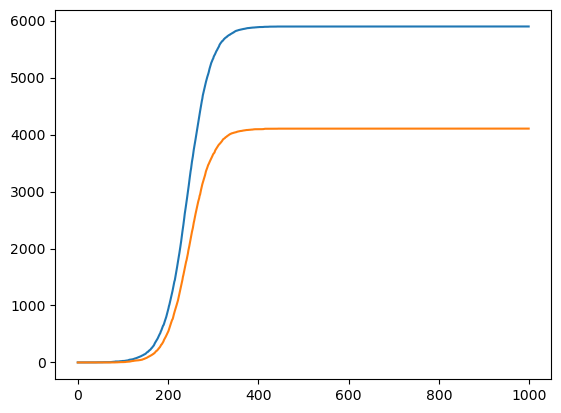

In [5]:
plt.plot(range(T), test_sim.I)

# Calculating Numerical Results

# Running Simulations